<a href="https://colab.research.google.com/github/lingchm/datascience/blob/master/exercises/socially_distanced_robots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Consumption in European Countries

*pca*

**Problem**

The goal is to study patterns of food consumption in Europea countries. We will use a dataset `food-consumption.csv` containing the consumption of 20 food items of 16 European countries. This data is represented as a data matrix with 16 rows and 20 columns. Each column is individual food across all di erent countries, i.e., a feature. The data set has 16 data points, each with 20 features. 

**Method**

One straightforward way to observe patterns is by plotting the data. Since the feature vector is high dimensional, it is not easily visualized. We will apply PCA on the feature vectors so that we can visualized the countries on a 2D graph. 

**References**

Credits to Dr. Yao Xie for designing this problem.

## Formulation of PCA

PCA is a dimension reduction algorithm. Its objective function is to find the top $k$ components that maximize the variance kept in data. 

Given $m$ data points, $\{x^1, \dots x^m\} \in \mathbb{R^n}$, with $\mu=\frac{1}{m} \sum_{i=1}^m  x^i$, we want to find a direction $w \in \mathbb{R^n}, ||w|| \leq 1$ such that the variance of data along the direction $w$ is maximized, leading to the optimization problem:
$$\max_{w: ||w|| \leq 1} \frac{1}{m} \sum_{i=1}^m (w^Tx^i - w^T \mu)^2$$

To simplify this,
$$\frac{1}{m} \sum_{i=1}^m (w^Tx^i - w^T \mu)^2 = \frac{1}{m} \sum_{i=1}^m w^T (x^i - \mu))^2 = \frac{1}{m} \sum_{i=1}^m w^T (x^i - \mu)(x^i - \mu)^T w = w^T \left ( \frac{1}{m} \sum_{i=1}^m (x^i - \mu)(x^i - \mu)^T \right ) w$$

So the simplified PCA optimization problem becomes:
$$\max_{w: ||w|| \leq 1} \frac{1}{m} \sum_{i=1}^m w^T C w$$
where $C = \frac{1}{m} \sum_{i=1}^m (x^i - \mu)(x^i - \mu)^T$ is the covariance matrix.

The form Lagrangian function of the optimization problem is 
$$L(w, \lambda) = w^TCw - \lambda(1-||w||^2)$$

If $w$ is the maximum of the original problem, then there exists a $\lambda$ where $(w, \lambda)$ is a stationary point of $L(w, \lambda)$, i.e. $L(w, \lambda) = 0$. So to find $w$ we take the derivative:
$$\frac{dL}{dw} = 2Cw - 2 \lambda w = 0  \Rightarrow Cw = \lambda w$$

which is the eigendecomposition of $C$. So we know the optimal $w$ should be an eigenvector of $C$. Now we want to find which eigenvalue $\lambda$ is associated with the optimal $w$:
$$\max  w^TCw = \max \lambda w^Tw = \max \lambda ||w||^2 $$

Clearly, the first optimal solution $w^1$ would be the largest eigenvector of $C$. This eigenvector correspond to the largest eigenvalue of $C, \lambda^1$. Therefore, the first principal component is obtained by using a weight vector corresponding to the eigenvector associated with the largest eigenvalue. 

To find the rest of the principal components, we would find the other solutions $w^2, \dots, w^k$ of $Cw = \lambda w$ by computing the eigendecomposition of $C$, getting the eigenvectors associated with the $k$ largest eigenvalues. This process can be implemented using python packages. The reduced representation or principle component of a data point becomes:
$$z^i = \frac{(w^i)^T (x^i-\mu)}{\sqrt{\lambda_1}}$$

## Implementation

The function `food_PCA` performs PCA on a given data matrix `A`. The number of components `k` needs to be preset. The other two parameters `feature` and `label` are utility parameters specific to this problem

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.io as spio
import scipy.sparse.linalg as ll
import sklearn.preprocessing as skpp
import pandas as pd

In [2]:
def food_PCA(A, K, feature, labels):
    if feature == "food":
        A = A.T                     # 20x16
    n, m = A.shape 

    # PCA
    mu = np.mean(A,axis = 1)         # 20 x 1
    xc = A - mu[:, None]
    C = np.dot(xc, xc.T)/m           # covariance matrix
    l, w = ll.eigs(C)        
    idx = l.argsort()[::-1][:K]      # k largest 
    l = l[idx].real
    w = w[:, idx].real

    # plot weight vectors
    for i in range(K):
        plt.title("Weight vector of component " + str(i+1))
        plt.stem(w[:,i])
        plt.show()

    # extract principal components and plot
    pc = np.empty([K, m])           # k x m 
    for i in range(K):
        pc[i, :] = np.dot(w[:,i].T, xc)/math.sqrt(l[i])

    # plt.stem(pc[0, :], pc[1, :])
    fig, ax = plt.subplots()
    ax.scatter(pc[0, :], pc[1, :])
    for i, txt in enumerate(labels):
        ax.annotate(txt, (pc[0, :][i], pc[1, :][i]))
    plt.title("First two principal components after PCA")
    plt.show()

In [3]:
# load data 
data = np.array(pd.read_csv('data/food-consumption.csv'))  # 16 countries x 21 foods
A = data[:, 1:21]
A = A.astype('float64')
country_labels = data[:,0]
food_labels = ["Real coffee","Instant coffee", "Tea	Sweetener",	"Biscuits",	"Powder", \
    "soup",	"Tin soup",	"Potatoes",	"Frozen fish", "Frozen veggies", "Apples",	"Oranges", \
    "Tinned fruit",	"Jam","Garlic","Butter","Margarine","Olive oil","Yoghurt","Crisp bread"]

In [4]:
# We will normalize the data because features have very different ranges, dividing by std
stdA = np.std(A, axis = 0)                  # 20 x 1, across all variables
stdA = skpp.normalize(stdA.reshape(1,-1))   # the normalize is different from MATLAB's, Scale input vectors individually to unit norm (vector length).
A = A @ np.diag(np.ones(stdA.shape[1])/stdA[0])  # A * [1,1,1,1]/||std||

## Results

**Food as feature vectors**

In the graph of the first component, we can observe that all features have positive weight except for two, which are garlic and olive oil, which are both cooking condiments.

In the graph of the second component, there is more variety. The most positive values correspond to instant coffee and powder soup, which are instantaneous liquids, followed by apples, oranges, tinned fruit; while the most negative weights correspond to real coffee, frozen fish, frozen vegetables, potatoes, and crisp bread. Overall, it seems that convenient food items that do not require much preparation tend to have positive weights; while the food items that require cooking tend to have negative weights.

The third plot visualizes the countries on a 2D graph. Interestingly, there seems to be some correspondence between the pattern of the graph and the geographical location of the countries. The countries that are close to each other appear close in the graph: the South-West countries Portugal, Italy, Spain, Austria on the top-left; the Northern countries Norway, Finland, Denmark, Sweden in the bottom-right, etc. 

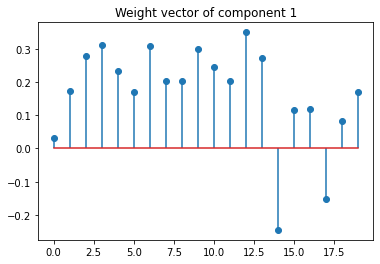

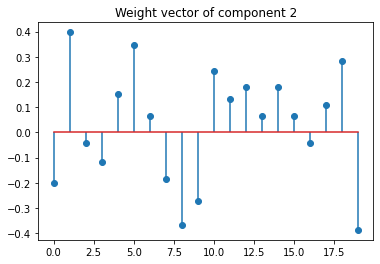

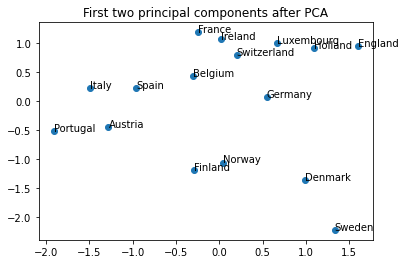

In [5]:
# food as feature vectors
food_PCA(A, K=2, feature="food", labels=country_labels)

**Country as feature vectors**

We rerun PCA using country as feature vectors.

The first two principal components for each data point is computed. The 2D representation of the food items using the first two principal components is shown below. Similarly to the observations made in part 3, the group of food that require cooking and/or preparation  are located on the top-right of the graph (frozen veggies, frozen fish, tin soup, potatoes, Jam, biscuit); whereas more convenient food items are located middle/right (apples, oranges, tea). The items at the bottom are mostly cooking condiments (garlic, olive oil).

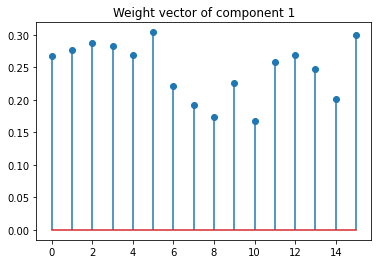

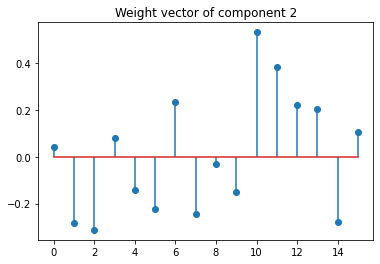

/Users/lingchm/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


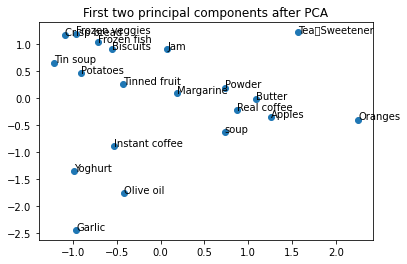

In [6]:
# country as feature vectors
food_PCA(A, K=2, feature="country", labels=food_labels)